In [2]:
from google.colab import files
uploaded = files.upload()

Saving semantics_results.csv to semantics_results.csv


In [3]:
import pandas as pd

df = pd.read_csv("./semantics_results.csv")

In [4]:
df.head()

,Input.text1,Input.text2,Answer.semantic-similarity.label,Input.run_type,Input.dataset,Title,Description
0,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...
1,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...
2,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...
3,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...
4,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...


In [5]:
label_map = { 'Strongly Agree': 5, 'Agree': 4, 'Not sure': 3, 'Disagree': 2, 'Strongly Disagree': 1}
df['label'] = df['Answer.semantic-similarity.label'].map(lambda s: label_map[s])

In [6]:
df

,Input.text1,Input.text2,Answer.semantic-similarity.label,Input.run_type,Input.dataset,Title,Description,label
0,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,4
1,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,4
2,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,4
3,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,4
4,"oh dear, oh dear! what were they thinking of ?...","oh dear, oh dear! what were they thinking of ?...",Agree,jin,imdb,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,4
...,...,...,...,...,...,...,...,...
3995,this is my favorite place for cupcakes they ha...,this is my advisable place for cupcakes they h...,Disagree,jin,yelp_polarity,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,2
3996,this is my favorite place for cupcakes they ha...,this is my advisable place for cupcakes they h...,Agree,jin,yelp_polarity,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,4
3997,this is my favorite place for cupcakes they ha...,this is my advisable place for cupcakes they h...,Agree,jin,yelp_polarity,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,4
3998,this is my favorite place for cupcakes they ha...,this is my advisable place for cupcakes they h...,Disagree,jin,yelp_polarity,Does changing from text1 to text2 preserve mea...,Compare two short pieces of English text and d...,2


In [7]:
!pip install textattack
!pip install bert-score

     |████████████████████████████████| 327kB 9.6MB/s 
     |████████████████████████████████| 778kB 15.2MB/s 
     |████████████████████████████████| 235kB 38.6MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 1.1MB 46.2MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 3.0MB 50.3MB/s 
     |████████████████████████████████| 153kB 58.1MB/s 
     |████████████████████████████████| 245kB 59.1MB/s 
     |████████████████████████████████| 686kB 50.4MB/s 
     |████████████████████████████████| 317kB 47.6MB/s 
     |████████████████████████████████| 1.8MB 47.4MB/s 
     |████████████████████████████████| 1.1MB 49.7MB/s 
     |████████████████████████████████| 890kB 50.4MB/s 
     |████████████████████████████████| 245kB 56.8MB/s 
     |████████████████████████████████| 17.7MB 215kB/s 
     |████████████████████████████████| 983kB 42.0MB

In [8]:
ref = df["Input.text1"][0]
cand = df["Input.text2"][0]

In [9]:
import bert_score
import torch
from tqdm import tqdm
bert_scorer = bert_score.BERTScorer(
            model_type="bert-base-uncased", idf=False, 
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        )
SCORE_TYPE2IDX = {"precision": 0, "recall": 1, "f1": 2}
# # df['bert_score'] = bert_scorer.score([df["Input.text2"]], [df["Input.text1"]])[SCORE_TYPE2IDX["f1"]].item()
# # result = bert_scorer.score([cand], [ref])
# # score = result[SCORE_TYPE2IDX["f1"]].item()
# # print(score)
bert_scores = []
for index, row in tqdm(df.iterrows()):
	cand = row["Input.text2"]
	ref = row["Input.text1"]
	result = bert_scorer.score([cand], [ref])
	score = result[SCORE_TYPE2IDX["f1"]].item()
	bert_scores.append(score)
df["bert_score"] = bert_scores

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1324: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
4000it [01:39, 40.23it/s]


In [10]:
from textattack.constraints.semantics.sentence_encoders import BERT
from textattack.shared import AttackedText
import string

scores = []
bert = BERT()
for index, row in tqdm(df.iterrows()):
  cand = row["Input.text2"]
  ref = row["Input.text1"]
  ref = AttackedText(ref)
  translator = str.maketrans('', '', string.punctuation)
  cand = ref.generate_new_attacked_text(cand.translate(translator).split(" "))
  score = float(bert._sim_score(ref, cand)[0])
  scores.append(score)
df["bert_sentence_score"] = scores

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


2020-11-06 10:24:35 INFO: Downloading default packages for language: en (English)...
2020-11-06 10:27:25 INFO: Finished downloading models and saved to /root/stanza_resources.
100%|██████████| 405M/405M [00:15<00:00, 26.5MB/s]
4000it [01:33, 42.77it/s]


General Pseudo-ish Code for adding new scores

In [ ]:
# scores = []
# for index, row in tqdm(df.iterrows()):
#   cand = row["Input.text2"]
#   ref = row["Input.text1"]
#   ref = AttackedText(ref)
#   score = scoring_function(ref, cand)
#   scores.append(score)
# df["column_name"] = scores

Analysis

In [31]:
df['label'].corr(df['bert_score'])

0.10056494675245772

In [33]:
for n in range(1, 6000//500+1):
  analysis_df = pd.DataFrame()
  # lengths = []
  for index, row in tqdm(df.iterrows()):
    # lengths.append(len(row['Input.text1']))
    if len(row['Input.text1']) < n*500 and len(row['Input.text1']) > (n-1)*500:
      analysis_df = analysis_df.append(row)
  print("Sentence length between %i and %i: Correlation = %f" % ((n-1)*500, n*500, analysis_df['label'].corr(analysis_df['bert_score'])))

4000it [00:08, 494.90it/s]
55it [00:00, 542.50it/s]

Sentence length between 0 and 500: Correlation = 0.160498


4000it [00:05, 710.39it/s]
436it [00:00, 4305.93it/s]

Sentence length between 500 and 1000: Correlation = 0.204126


4000it [00:02, 1575.19it/s]
270it [00:00, 2650.54it/s]

Sentence length between 1000 and 1500: Correlation = 0.140261


4000it [00:01, 3168.81it/s]
247it [00:00, 2449.02it/s]

Sentence length between 1500 and 2000: Correlation = 0.103375


4000it [00:00, 4995.64it/s]
808it [00:00, 8029.70it/s]

Sentence length between 2000 and 2500: Correlation = 0.063089


4000it [00:00, 7117.87it/s]
756it [00:00, 7556.12it/s]

Sentence length between 2500 and 3000: Correlation = 0.269550


4000it [00:00, 8559.07it/s]
1105it [00:00, 11044.93it/s]

Sentence length between 3000 and 3500: Correlation = 0.165533


4000it [00:00, 8800.93it/s]
1209it [00:00, 12082.61it/s]

Sentence length between 3500 and 4000: Correlation = 0.560449


4000it [00:00, 10734.22it/s]
1191it [00:00, 11904.82it/s]

Sentence length between 4000 and 4500: Correlation = nan


4000it [00:00, 10797.04it/s]
1169it [00:00, 11677.71it/s]

Sentence length between 4500 and 5000: Correlation = nan


4000it [00:00, 9215.39it/s]
1191it [00:00, 11436.65it/s]

Sentence length between 5000 and 5500: Correlation = -0.817624


4000it [00:00, 9472.40it/s]

Sentence length between 5500 and 6000: Correlation = nan


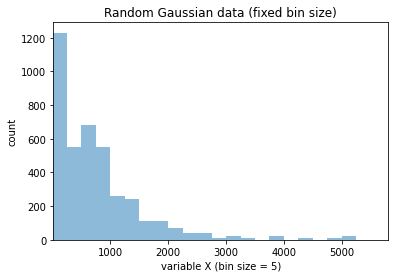

In [30]:
import numpy as np
import random
from matplotlib import pyplot as plt

# fixed bin size
bins = np.arange(0, 6000, 250) # fixed bin size

plt.xlim([min(lengths)-5, max(lengths)+5])

plt.hist(lengths, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

In [34]:
df['label'].corr(df['bert_sentence_score'])

0.0621164308017006

In [35]:
for n in range(1, 6000//500+1):
  analysis_df = pd.DataFrame()
  # lengths = []
  for index, row in tqdm(df.iterrows()):
    # lengths.append(len(row['Input.text1']))
    if len(row['Input.text1']) < n*500 and len(row['Input.text1']) > (n-1)*500:
      analysis_df = analysis_df.append(row)
  print("Sentence length between %i and %i: Correlation = %f" % ((n-1)*500, n*500, analysis_df['label'].corr(analysis_df['bert_sentence_score'])))

4000it [00:07, 508.04it/s]
86it [00:00, 434.98it/s]

Sentence length between 0 and 500: Correlation = 0.101494


4000it [00:05, 750.59it/s]
438it [00:00, 4283.04it/s]

Sentence length between 500 and 1000: Correlation = 0.244453


4000it [00:02, 1675.82it/s]
284it [00:00, 2839.03it/s]

Sentence length between 1000 and 1500: Correlation = 0.210087


4000it [00:01, 3165.15it/s]
250it [00:00, 2448.11it/s]

Sentence length between 1500 and 2000: Correlation = 0.195524


4000it [00:00, 5043.21it/s]
809it [00:00, 7908.06it/s]

Sentence length between 2000 and 2500: Correlation = 0.330533


4000it [00:00, 7673.79it/s]
831it [00:00, 8303.53it/s]

Sentence length between 2500 and 3000: Correlation = 0.182078


4000it [00:00, 8939.43it/s]
1167it [00:00, 11669.20it/s]

Sentence length between 3000 and 3500: Correlation = 0.096157


4000it [00:00, 9414.22it/s]
1248it [00:00, 12477.01it/s]

Sentence length between 3500 and 4000: Correlation = 0.560449


4000it [00:00, 10908.03it/s]
1138it [00:00, 11377.22it/s]

Sentence length between 4000 and 4500: Correlation = nan


4000it [00:00, 10111.23it/s]
1220it [00:00, 12197.39it/s]

Sentence length between 4500 and 5000: Correlation = nan


4000it [00:00, 10133.27it/s]
1192it [00:00, 11670.83it/s]

Sentence length between 5000 and 5500: Correlation = 0.817624


4000it [00:00, 9189.44it/s]

Sentence length between 5500 and 6000: Correlation = -0.196116
